# Import

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from kesacco import clustpipe

# Parameters

### Define the simulation

In [2]:
cpipe = clustpipe.ClusterPipe(silent=False, output_dir='/Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev')

             _  __  ___    __    __     ___   ___   __         
            | |/ / | __| /' _/  /  \   / _/  / _/  /__\        
            |   <  | _|  `._`. | /\ | | \__ | \__ | \/ |       
            |_|\_\ |___| |___/ |_||_|  \__/  \__/  \__/        
Keen Event Simulation and Analysis for CTA Cluster Observations
---------------------------------------------------------------


### Define the cluster object

In [3]:
# Set the cluster basic properties
cpipe.cluster.name     = 'Perseus'
cpipe.cluster.redshift = 0.017284
cpipe.cluster.M500     = 6.2e14*u.solMass # Used for getting R500 and the pressure profile
cpipe.cluster.coord    = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')

# Truncate the cluster at 1.5 deg to allow small map field of view (for faster code) without loss of flux
cpipe.cluster.theta_truncation = 1.5*u.deg

# The target gas density [Churazov et al. 2003]
cpipe.cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':57*u.kpc, 'n_01':0.046*u.cm**-3,
                                   'beta2':0.71, 'r_c2':278*u.kpc, 'n_02':0.0036*u.cm**-3}

# The thermal profile (assuming Planck 2013 UPP)
cpipe.cluster.set_pressure_gas_gNFW_param('P13UPP')

# CR physics
cpipe.cluster.X_cre1_E = {'X':0.0, 'R_norm':cpipe.cluster.R500}
cpipe.cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.2}
cpipe.cluster.set_density_crp_isobaric_scal_param(scal=1.0)
cpipe.cluster.X_crp_E = {'X':1.0, 'R_norm':cpipe.cluster.R500}

# Sampling
cpipe.cluster.map_reso = 0.01*u.deg      # Ideally should be few times smaller than the PSF
cpipe.cluster.Npt_per_decade_integ = 30

# Get information about the state of the cluster model
cpipe.cluster.print_param()

--- silent
    True
    <class 'bool'>
--- output_dir
    /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev
    <class 'str'>
--- cosmo
    FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
    <class 'astropy.cosmology.core.FlatLambdaCDM'>
--- name
    Perseus
    <class 'str'>
--- coord
    <SkyCoord (ICRS): (ra, dec) in deg
    (49.94666667, 41.51305556)>
    <class 'astropy.coordinates.sky_coordinate.SkyCoord'>
--- redshift
    0.017284
    <class 'float'>
--- D_ang
    74.8907830317466 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- D_lum
    77.50198024167615 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    620000000000000.0 solMass
    <class 'astropy.units.quantity.Quantity'>
--- R500
    1317.548394363056 kpc
    <class 'astropy.units.quantity.Quantity'>
--- theta500
    1.0080007077672122 deg
    <class 'astropy.units.quantity.Quantity'>
--- R_truncation
    1.9606361149510187 Mpc

### Define the point source object

In [4]:
name='NGC1275'
spatial={'type':'PointSource',
         'param':{'RA': {'value':SkyCoord("3h19m48.16s +41d30m42s").ra.to('deg'),  'free':False},
                  'DEC':{'value':SkyCoord("3h19m48.16s +41d30m42s").dec.to('deg'), 'free':False}}}
spectral={'type':'PowerLaw',
          'param':{'Prefactor':{'value':2.1e-11/u.cm**2/u.TeV/u.s, 'free':True},
                   'Index':{'value':-3.6, 'free':True},
                   'PivotEnergy':{'value':0.2*u.TeV, 'free':False}}}

cpipe.compact_source.add_source(name, spatial, spectral, redshift=cpipe.cluster.redshift)

In [5]:
name='IC310'
spatial={'type':'PointSource',
         'param':{'RA': {'value':SkyCoord("3h16m42.98s +41d19m30s").ra.to('deg'),  'free':False},
                  'DEC':{'value':SkyCoord("3h16m42.98s +41d19m30s").dec.to('deg'), 'free':False}}}
spectral={'type':'PowerLaw',
          'param':{'Prefactor':{'value':4.3e-12/u.cm**2/u.TeV/u.s, 'free':True},
                   'Index':{'value':-1.95, 'free':True},
                   'PivotEnergy':{'value':1.0*u.TeV, 'free':False}}}

cpipe.compact_source.add_source(name, spatial, spectral, redshift=cpipe.cluster.redshift)

In [6]:
# Show the status of the compact sources in the sky model
cpipe.compact_source.print_source()

--- NGC1275 at z=0.017284
    -- Spatial model: PointSource
         RA: {'value': <Longitude 49.95066667 deg>, 'free': False}
         DEC: {'value': <Latitude 41.51166667 deg>, 'free': False}
    -- Spectral model: PowerLaw
         Prefactor: {'value': <Quantity 2.1e-11 1 / (cm2 s TeV)>, 'free': True}
         Index: {'value': -3.6, 'free': True}
         PivotEnergy: {'value': <Quantity 0.2 TeV>, 'free': False}
    -- Temporal model: Constant
         Normalization: {'value': 1.0, 'free': False}
--- IC310 at z=0.017284
    -- Spatial model: PointSource
         RA: {'value': <Longitude 49.17908333 deg>, 'free': False}
         DEC: {'value': <Latitude 41.325 deg>, 'free': False}
    -- Spectral model: PowerLaw
         Prefactor: {'value': <Quantity 4.3e-12 1 / (cm2 s TeV)>, 'free': True}
         Index: {'value': -1.95, 'free': True}
         PivotEnergy: {'value': <Quantity 1. TeV>, 'free': False}
    -- Temporal model: Constant
         Normalization: {'value': 1.0, 'free': Fals

### Define the observations

In [7]:
# One pointing offset +0 +1
cpipe.obs_setup.add_obs(obsid='001', name='Perseus_Ptg1', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+0, cpipe.cluster.coord.dec.value+1, unit='deg'),
                        rad=5*u.deg,
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-01T00:00:00.0', tmax='2020-01-01T01:00:00.0', deadc=0.95)

# One pointing offset +0 -1
cpipe.obs_setup.add_obs(obsid='002', name='Perseus_Ptg2', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+0, cpipe.cluster.coord.dec.value-1, unit='deg'),
                        rad=5*u.deg, 
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-02T00:00:00.0', tmax='2020-01-02T01:00:00.0', deadc=0.95)

# One pointing offset +1 +0
cpipe.obs_setup.add_obs(obsid='003', name='Perseus_Ptg3', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+1, cpipe.cluster.coord.dec.value+0, unit='deg'),
                        rad=5*u.deg,
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-03T00:00:00.0', tmax='2020-01-03T01:00:00.0', deadc=0.95)

# One pointing offset -1 +0
cpipe.obs_setup.add_obs(obsid='004', name='Perseus_Ptg4', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value-1, cpipe.cluster.coord.dec.value+0, unit='deg'),
                        rad=5*u.deg,
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-04T00:00:00.0', tmax='2020-01-04T01:00:00.0', deadc=0.95)

# Print info
cpipe.obs_setup.print_obs()

=== Perseus_Ptg1, ObsID 001
        RA-Dec:    49.94666666666666, 42.51305555555555 deg
        GLON-GLAT: 150.0078784158764, -12.426877669678154 deg
        ROI rad: 5.0 deg
        tmin: 2020-01-01T00:00:00.0
        tmax: 2020-01-01T01:00:00.0
        emin: 0.05 TeV
        emax: 100.0 TeV
        deadc: 0.95
        caldb: prod3b-v2
        irf: North_z20_S_5h
        bkg: name Background, obsid None, spatial type CTAIrfBackground, spectral type PowerLaw
=== Perseus_Ptg2, ObsID 002
        RA-Dec:    49.94666666666666, 40.51305555555555 deg
        GLON-GLAT: 151.14097159102025, -14.095338103823554 deg
        ROI rad: 5.0 deg
        tmin: 2020-01-02T00:00:00.0
        tmax: 2020-01-02T01:00:00.0
        emin: 0.05 TeV
        emax: 100.0 TeV
        deadc: 0.95
        caldb: prod3b-v2
        irf: North_z20_S_5h
        bkg: name Background, obsid None, spatial type CTAIrfBackground, spectral type PowerLaw
=== Perseus_Ptg3, ObsID 003
        RA-Dec:    50.94666666666666, 41.5130

# Run the simulation

# Run the analysis

In [8]:
#----- Analysis parameters
cpipe.method_binned = True    # Do a binned analysis
cpipe.method_stack  = True    # Stack the event from different observations in a single analysis?
cpipe.method_ana    = '3D'    # 3D or ONOFF analysis
cpipe.spec_enumbins = 30
cpipe.spec_emin     = 50*u.GeV
cpipe.spec_emax     = 10*u.TeV
cpipe.spec_edisp    = False

# Force the use of the user defined map grid
cpipe.map_UsePtgRef     = True
# Define the map used for the binned analysis
cpipe.map_reso          = 0.05*u.deg # Can be increaded if the code is too slow
cpipe.map_fov           = 3*u.deg    # Can also be reduced (but should increase bkg-cluster degeneracy)
cpipe.map_coord         = copy.deepcopy(cpipe.cluster.coord)
# Define the map used for the template
cpipe.cluster.map_fov   = 2.1*cpipe.cluster.theta_truncation
cpipe.cluster.map_coord = copy.deepcopy(cpipe.cluster.coord)

In [18]:
cpipe.run_ana_spectral(name='Perseus', do_Res=False)


            Starting the spectral analysis            

--- Computing spectrum: Perseus
=== GApplication ===
 Name ......................: csspec
 Version ...................: 1.7.3
 inobs .....................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_Countscube.fits
 inmodel ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_Model_Output.xml
 srcname ...................: Perseus
 expcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_Expcube.fits
 psfcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_Psfcube.fits
 edispcube .................: NONE
 bkgcube ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_Bkgcube.fits
 caldb .....................: prod2
 irf .......................: South_0.5h
 edisp .....................: no
 outfile ...................: /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_Spectrum_Perseus.fits
 method ....................: SLICE
 ebina

In [19]:
hdul = fits.open('/Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_Spectrum_Perseus.fits')
dat = hdul[1].data
dat.columns

ColDefs(
    name = 'e_ref'; format = '1D'; unit = 'TeV'
    name = 'e_min'; format = '1D'; unit = 'TeV'
    name = 'e_max'; format = '1D'; unit = 'TeV'
    name = 'norm'; format = '1D'
    name = 'norm_err'; format = '1D'
    name = 'norm_ul'; format = '1D'
    name = 'ref_e2dnde'; format = '1D'; unit = 'erg/cm2/s'
    name = 'ref_dnde'; format = '1D'; unit = 'counts/MeV/cm2/s'
    name = 'ts'; format = '1D'
    name = 'ref_npred'; format = '1D'; unit = 'counts'
    name = 'loglike'; format = '1D'
    name = 'norm_scan'; format = '15D'
    name = 'dloglike_scan'; format = '15D'
)

In [23]:
e_lo = dat['e_ref']-dat['e_min']
e_hi = dat['e_ref']+dat['e_max']
e_ct = dat['e_ref']

In [43]:
model_ct = cpipe.cluster.get_gamma_spectrum(e_ct*u.TeV, Rmax=cpipe.cluster.R_truncation)[1]
model_lo = cpipe.cluster.get_gamma_spectrum(e_lo*u.TeV, Rmax=cpipe.cluster.R_truncation)[1]
model_hi = cpipe.cluster.get_gamma_spectrum(e_hi*u.TeV, Rmax=cpipe.cluster.R_truncation)[1]

slope = np.log10(model_lo.value/model_hi.value)/np.log10(e_lo/e_hi)
ampli = model_lo/e_lo**slope
model_re = 1/(slope+1)/(e_hi-e_lo)*(e_hi*model_hi - e_lo*model_lo)

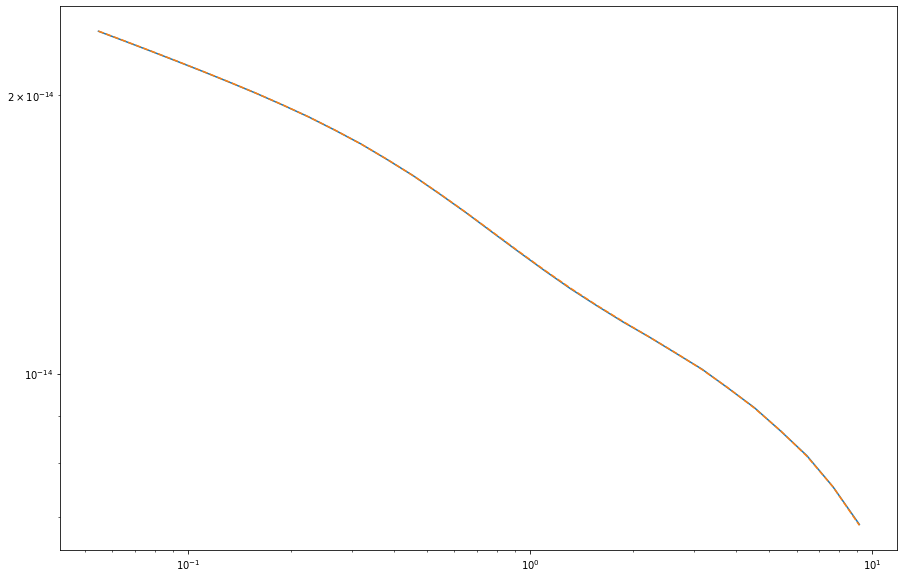

In [48]:
plt.figure(0, figsize=(15,10))
#plt.loglog(e_ct, model_ct-model_re)
plt.loglog(e_ct, e_ct**2*model_ct)
plt.loglog(e_ct, e_ct**2*model_re, linestyle='--')